# Lab 6 - Model comparison

In this excercise we will learn about comparing models using metrics predicting out of sample behavior.

Main idea is to instead of splitting the dataset into two parts (test and training set) to estimate how model would behave in presence of new data. This is being done by evaluating so called log likelihood which is an array of values of logarithm of likelihood for each of datapoints individually.

We will use this informations with two metrics:

- Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model
- PSIS-LOOCV - Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time.
For this excercise code is provided in form of print-screens.

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import scipy.stats as norm
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - generate data

1. Compile code_1.stan and code_2.stan
2. Generate data for rest of excercises.

Model code_1

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,0.01,0.882114,-0.027807,0.206516,-0.352780,-1.018610,0.434381,-0.249495,...,1.332650,0.058548,-0.971073,0.554340,-0.016589,0.497976,-1.079170,-0.432914,-8.890110,-0.780714
1,0.0,0.0,0.01,1.299350,-0.164556,-0.472721,-0.428902,1.346180,-0.485991,1.163750,...,1.132830,-0.046011,0.435390,0.897786,2.813100,-1.792900,-0.862041,-0.797624,-1.218930,0.830078
2,0.0,0.0,0.01,-0.836886,0.811120,-0.721798,-0.033321,1.130320,-0.159432,2.073750,...,-0.662821,0.948946,-0.592176,0.425075,0.866227,-2.030510,0.464473,0.234576,1.536530,-1.071810
3,0.0,0.0,0.01,-1.340210,-0.244405,-0.723175,0.324987,-0.080402,-0.775644,-0.069699,...,0.504568,-1.057570,-1.038990,-0.082195,1.063620,-0.730687,0.484496,0.837560,0.050793,-0.369971
4,0.0,0.0,0.01,1.919420,1.332200,-1.766910,1.542140,1.145390,0.153620,-0.110181,...,-0.173292,-0.199130,-0.142752,0.961440,-0.097544,-0.869505,0.787372,-0.917846,1.075660,-0.405036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.01,-0.060644,2.128260,-0.101170,0.148592,0.538864,-0.622013,0.429763,...,0.487951,0.129722,-1.906430,5.772750,-2.021670,1.395580,0.549066,1.296460,-1.543870,-0.794926
996,0.0,0.0,0.01,1.246500,-0.579106,0.116658,0.974399,0.467468,21.825900,0.232935,...,-0.550121,0.419713,-0.447254,1.623180,0.804656,-0.969296,0.017896,-0.114567,-0.265008,0.541135
997,0.0,0.0,0.01,1.238220,-0.950802,1.274320,-0.665728,-0.265518,-2.747950,-0.417182,...,-0.839582,-1.414900,0.404070,0.774315,0.952836,0.266694,-0.484455,-0.170028,-0.242699,1.071270
998,0.0,0.0,0.01,1.426180,-0.507687,1.440860,-0.594541,-0.358100,0.726692,1.262570,...,0.104521,1.219120,0.854749,1.944970,0.127194,-0.788249,-1.045040,1.106980,-0.539437,-0.236965


array([ 0.882114 , -0.0278073,  0.206516 , ..., -0.432914 , -8.89011  ,
       -0.780714 ])

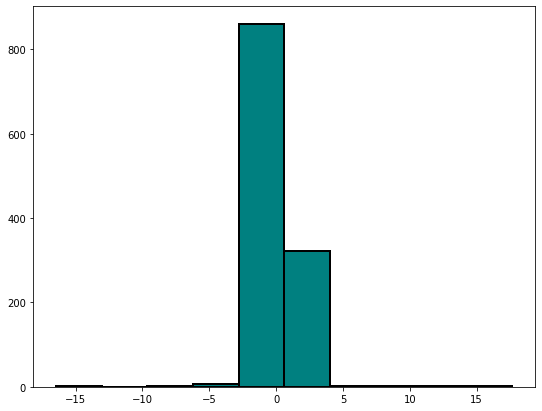

In [3]:
F = len('Daniel')        # F - number of letters in first name 
L = len('Sędłak')        # L - number of letters in last name 
N = (L+F)*100            # N = (L+F)*100

# Compile code_1
model_1 = CmdStanModel(stan_file='code_1.stan')

samples_1 = model_1.sample(data={'N': N}, 
                           iter_sampling=1000, 
                           iter_warmup=0, 
                           chains = 1)

# Creation of pandas dataframe from resulting draws
df = samples_1.draws_pd()
display(df)

y1 = samples_1.stan_variable('y')[0]
# y1 = df['y[1]']
display(y1)

# Create plot
fig, axes = plt.subplots(1, 1, figsize=(9, 7))
plt.hist(y1, bins=10, color='teal', edgecolor='black', linewidth=2)
plt.show()

Model code_2

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,-0.140832,-1.561980,-1.636780,0.335736,1.499810,-0.994227,-1.070670,-0.023816,...,-2.130810,-1.189290,2.865350,7.870640,-1.691300,-0.802393,0.776735,2.628360,2.136930,1.630010
1,0.0,0.0,0.202141,-0.260315,0.585259,-0.452830,1.529400,0.153736,-0.195366,1.392020,...,-2.191630,-2.352160,-3.384310,1.075970,4.431810,-1.807900,-5.044440,-2.626370,-5.765270,-0.802191
2,0.0,0.0,-0.456413,-0.180263,-1.301320,2.232530,0.289708,0.476910,-1.638350,-2.174160,...,-0.646315,-1.704380,0.383712,1.818910,2.324510,-3.949600,1.482710,-3.605650,3.153010,-6.270270
3,0.0,0.0,0.279794,-0.203628,1.201110,-0.899134,-1.140190,-0.324735,1.389790,1.226190,...,-1.605940,-0.363363,0.153724,-0.805175,-1.963100,-1.263930,0.022798,-1.313600,-2.182920,2.577740
4,0.0,0.0,0.348776,-0.265699,-1.531030,-0.694173,0.456167,0.474983,0.255604,-0.418313,...,-2.000120,-1.175150,0.446365,0.783256,4.000120,2.857180,-0.020524,-1.401290,-2.102620,-0.004156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,-2.353740,0.090482,-0.732292,-0.499606,-0.923413,-0.912099,-0.849935,1.336330,...,2.118020,-2.552470,4.142260,-2.024150,-3.780660,-1.264680,1.103400,0.383159,-2.145610,3.021150
996,0.0,0.0,0.270136,-0.553161,0.059787,-1.055350,0.513662,-0.198208,0.852700,-0.101736,...,1.314490,2.122210,-0.631799,3.157560,1.512870,0.582129,-0.954187,1.667510,0.010974,1.131670
997,0.0,0.0,0.380478,1.178380,1.535220,-0.309484,-0.731689,0.142871,0.217178,0.540793,...,1.392420,2.692600,-2.133420,-2.474850,-0.036618,3.085350,-1.138340,2.520750,-5.243530,0.880133
998,0.0,0.0,-0.556248,-0.339797,0.868489,1.070590,0.886584,-1.787650,-0.644698,-0.933978,...,2.581170,-5.078500,2.860560,-4.964700,-0.745088,4.592700,-0.467272,1.140220,0.920681,-0.900623


array([-0.39518, -3.7702 , -5.5761 , ...,  2.62836,  2.13693,  1.63001])

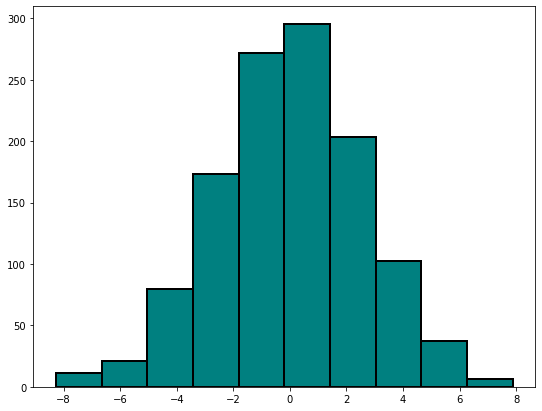

In [4]:
# F = len('Daniel')        # F - number of letters in first name 
# L = len('Sędłak')        # L - number of letters in last name 
# N = (L+F)*100            # N = (L+F)*100

# Compile code_2
model_2 = CmdStanModel(stan_file='code_2.stan')

samples_2 = model_2.sample(data={'N': N}, 
                           iter_sampling=1000, 
                           iter_warmup=0, 
                           chains = 1)

# Creation of pandas dataframe from resulting draws
df = samples_2.draws_pd()
display(df)

# Create plot
# y2 = df['y[1]']
y2 = samples_2.stan_variable('y')[0]
display(y2)

fig, axes = plt.subplots(1, 1, figsize=(9, 7))
plt.hist(y2, bins=10, color='teal', edgecolor='black', linewidth=2)
plt.show()

## Excercise 2 - compare normal and student models for data from first file

1. Compile both models
2. Fit both models
3. Using az.compare and az.plot_compare analyze both models using ```loo``` and ```waic``` criteria.

### 1. Compile models

In [5]:
# F = len('Daniel')        # F - number of letters in first name 
# L = len('Sędłak')        # L - number of letters in last name 
# N = (L+F)*100            # N = (L+F)*100

model_3 = CmdStanModel(stan_file='code_3.stan')

#--------------------------------------------------#

model_4 = CmdStanModel(stan_file='code_4.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


### 2. Fit models

In [6]:
# Fit the model code_3.stan
fit3_1 = model_3.sample(data={'N': N, 'y': y1}, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains=1)

fit3_2 = model_3.sample(data={'N': N, 'y': y2}, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains = 1)

# Creation of pandas dataframe from resulting draws
df = fit3_1.draws_pd()
display(df)


# Fit the model code_4.stan
fit4_1 = model_4.sample(data={'N': N, 'y': y1}, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains=1)

fit4_2 = model_4.sample(data={'N': N, 'y': y2}, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains = 1)

# Creation of pandas dataframe from resulting draws
df = fit4_1.draws_pd()
display(df)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-2335.72,0.0,7.84723,0.0,1.0,1.0,2337.07,1.93371,0.396624,-1.60989,...,0.127125,-2.767030,-2.594810,-2.640820,-1.778270,2.201570,2.135170,1.828180,-0.991931,-0.813790
1,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.01,1.93371,0.396624,-1.60989,...,-0.235490,1.510910,-0.044928,-4.957870,-0.780542,-1.405240,4.827080,1.167250,0.076098,-2.152010
2,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.72,1.93371,0.396624,-1.60989,...,2.156120,-0.915373,-1.397150,2.573480,2.165950,-0.001867,-0.432904,-1.597610,-0.497640,1.547820
3,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.04,1.93371,0.396624,-1.60989,...,3.191850,-2.134850,3.496490,-0.084145,-0.817558,0.739490,1.287900,-0.457660,1.317380,0.219723
4,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.33,1.93371,0.396624,-1.60989,...,1.526230,-0.228396,1.615470,-1.786050,2.880690,1.555400,0.145381,-0.056105,-3.319260,1.062440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2335.72,0.0,7.84723,0.0,1.0,1.0,2338.40,1.93371,0.396624,-1.60989,...,2.225060,0.603160,0.079627,-1.757740,-1.669590,1.423610,-0.110071,0.079314,2.081180,-2.939310
996,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.07,1.93371,0.396624,-1.60989,...,-0.109320,-1.282280,-0.279126,0.476611,2.515340,1.275680,2.424370,-2.579140,-3.227520,-1.275330
997,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.57,1.93371,0.396624,-1.60989,...,3.400910,-2.743840,-1.828810,3.114640,1.632770,5.678520,0.838859,-4.623420,0.660527,-0.539295
998,-2335.72,0.0,7.84723,0.0,1.0,1.0,2336.93,1.93371,0.396624,-1.60989,...,-0.525223,-0.242457,-1.433260,-0.163987,-2.086070,1.160930,0.266785,-0.524268,4.262290,-1.676570


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-2181.76,0.0,14.3855,0.0,1.0,1.0,2181.91,0.795279,0.495582,0.846665,...,12.281300,-8.901900,0.716986,0.384064,-0.962338,0.493412,0.802147,-0.630451,0.918542,-2.759420
1,-2181.76,0.0,14.3855,0.0,1.0,1.0,2183.07,0.795279,0.495582,0.846665,...,8.915350,0.970956,0.979203,0.336605,-3.162790,-0.015699,1.780040,0.708543,0.787641,-0.043171
2,-2181.76,0.0,14.3855,0.0,1.0,1.0,2183.58,0.795279,0.495582,0.846665,...,1.574590,0.667404,5.757690,1.473360,0.106546,1.969590,-0.066388,-3.293210,2.336290,-0.063962
3,-2181.76,0.0,14.3855,0.0,1.0,1.0,2182.76,0.795279,0.495582,0.846665,...,0.433157,0.077783,0.998758,4.102040,12.505800,0.309738,11.135200,13.966900,1.941820,-0.849548
4,-2181.76,0.0,14.3855,0.0,1.0,1.0,2184.77,0.795279,0.495582,0.846665,...,0.196417,1.034540,-0.682953,-0.359417,0.691309,-0.028591,7.738870,0.320666,5.174970,3.079190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2181.76,0.0,14.3855,0.0,1.0,1.0,2184.81,0.795279,0.495582,0.846665,...,-3.837620,-0.118881,0.252437,-0.519966,0.043653,0.714659,0.793917,1.596040,-0.985766,1.882490
996,-2181.76,0.0,14.3855,0.0,1.0,1.0,2183.71,0.795279,0.495582,0.846665,...,-0.133172,0.415149,0.685253,-4.272460,3.728290,-9.694020,0.211941,-1.447030,-0.074943,3.697280
997,-2181.76,0.0,14.3855,0.0,1.0,1.0,2182.22,0.795279,0.495582,0.846665,...,0.246752,-8.989590,1.386720,4.183340,-1.415730,2.434660,2.630650,1.495970,1.201760,0.398195
998,-2181.76,0.0,14.3855,0.0,1.0,1.0,2181.77,0.795279,0.495582,0.846665,...,-3.740600,-0.135943,1.224530,-0.514902,0.016384,1.140460,0.244867,-2.151820,2.732010,-0.085642


### 3. Using az.compare and az.plot_compare analyze both models using ```loo``` and ```waic``` criteria.

#### WAIC criteria

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_4,0,-2176.961363,2.526574e-28,0.000000,0.472958,28.359507,0.000000,False,log
model_3,1,-2335.057450,7.946295e-28,158.096087,0.527042,84.099958,72.594445,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_4,0,-2849.26508,3.951207e-28,0.00000,0.980857,25.423102,0.000000,False,log
model_3,1,-2970.94541,4.672029e-28,121.68033,0.019143,21.725668,14.432719,False,log


Text(0.5, 1.0, 'Data from model_2 - WAIC criteria')

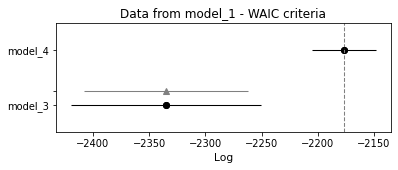

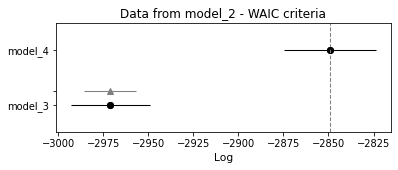

In [7]:
dict_1 = {'model_3': fit3_1,'model_4': fit4_1}
dict_2 = {'model_3': fit3_2,'model_4': fit4_2}

# Compare model_1
model_waic_1_compare = az.compare(dict_1, ic = 'waic')
display(model_waic_1_compare.head())

az.plot_compare(model_waic_1_compare)
plt.title('Data from model_1 - WAIC criteria')

# Compare model_2
model_waic_2_compare = az.compare(dict_2, ic = 'waic')
display(model_waic_2_compare.head())

az.plot_compare(model_waic_2_compare)
plt.title('Data from model_2 - WAIC criteria')

Based on the comparison between the two models, model 4 appears to be more reliable in both scenarios. In the case of future data, model 4's middle value is comparable to the dataset value, indicating that it will perform better. Similarly, when using the current data, model 4 outperforms model 2 due to its wider range that includes the values of the dataset.

#### LOO criteria 

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_4,0,-2176.961363,0.0,0.000000,0.472958,28.359507,0.000000,True,log
model_3,1,-2335.057450,0.0,158.096087,0.527042,84.099958,72.594445,True,log


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_4,0,-2849.26508,0.0,0.00000,0.980857,25.423102,0.000000,True,log
model_3,1,-2970.94541,0.0,121.68033,0.019143,21.725668,14.432719,True,log


Text(0.5, 1.0, 'Data from model_2 - LOO criteria')

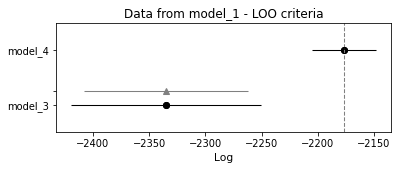

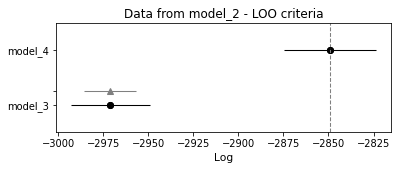

In [8]:
dict_1 = {'model_3': fit3_1,'model_4': fit4_1}
dict_2 = {'model_3': fit3_2,'model_4': fit4_2}

# Compare model_1
model_loo_1_compare = az.compare(dict_1, ic="loo", method="stacking")
display(model_loo_1_compare.head())

az.plot_compare(model_loo_1_compare)
plt.title('Data from model_1 - LOO criteria')

# Compare model_2
model_loo_2_compare = az.compare(dict_2, ic = 'loo', method="stacking")
display(model_loo_2_compare.head())

az.plot_compare(model_loo_2_compare)
plt.title('Data from model_2 - LOO criteria')

## Excercise 3 - compare models with different numbers of predictors

1. Compile model
2. Compare models for 1, 2 and 3 predictors as in previous excercise

### 1. Compile model

In [9]:
# F = len('Daniel')        # F - number of letters in first name 
# L = len('Sędłak')        # L - number of letters in last name 
# N = (L+F)*100            # N = (L+F)*100

# Compile model_5
model_5 = CmdStanModel(stan_file='code_5.stan')

# df = samples_2.draws_pd()
# # display(df)
# x2 = df['X']

# Initially, the x2 matrix is changed from the shape (10000, 3) to the shape (1000, -1), i.e. to a matrix of 1000 rows 
# and as many columns as needed to retain all the elements from the original matrix. Each of the three smaller matrices 
# is then extracted from the initial rows of the x2 matrix with the specified number of rows and all columns. Finally, 
# each of these three smaller matrices is transposed to have one row per observation for use in a probabilistic model.

x2 = samples_2.stan_variable('X')

x2_1 = x2.reshape(1000,-1)[0:1,:N]
x2_1 = np.transpose(x2_1)

x2_2 = x2.reshape(1000,-1)[0:2,:N]
x2_2 = np.transpose(x2_2)

x2_3 = x2.reshape(1000,-1)[0:3,:N]
x2_3 = np.transpose(x2_3)

# Generate some data with 3 predictors
fit5_1 = model_5.sample(data={'N':N, 'K': 1, 'y':y2,'X':x2_1},
                        fixed_param=True, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains = 1)

fit5_2 = model_5.sample(data={'N':N, 'K': 2, 'y':y2,'X':x2_2},
                        fixed_param=True, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains = 1)
                            
fit5_3 = model_5.sample(data={'N':N, 'K': 3, 'y':y2,'X':x2_3},
                        fixed_param=True, 
                        iter_sampling=1000, 
                        iter_warmup=1, 
                        chains = 1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


### 2. Compare models for 1, 2 and 3 predictors
Using az.compare and az.plot_compare analyze models using ```loo``` and ```waic``` criteria.

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated sh

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
fit5_3,0,-20433.951874,0.0,0.000000,0.718296,820.104137,0.000000,True,log
fit5_1,1,-82709.873309,0.0,62275.921435,0.219315,3427.446469,3240.049083,True,log
fit5_2,2,-253956.638602,0.0,233522.686727,0.062389,10117.417940,9772.735181,True,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fit5_3,0,-20433.951874,5.514171e-26,0.000000,0.718296,820.104137,0.000000,False,log
fit5_1,1,-82709.873309,9.589636e-25,62275.921435,0.219315,3427.446469,3240.049083,False,log
fit5_2,2,-253956.638602,8.099948e-24,233522.686727,0.062389,10117.417940,9772.735181,False,log


Text(0.5, 1.0, 'Data from model_5 - WAIC criteria')

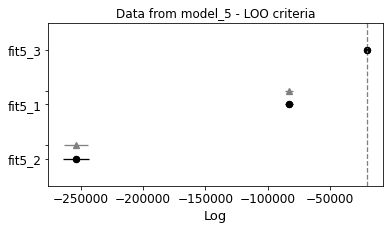

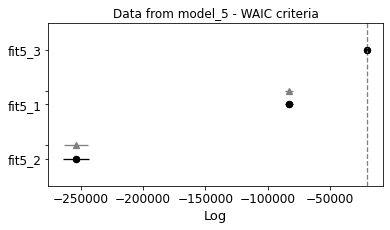

In [10]:
dict_model_5 = {'fit5_1': fit5_1, 'fit5_2': fit5_2, 'fit5_3': fit5_3}

model_5_loo_compare = az.compare(dict_model_5, ic="loo")
display(model_5_loo_compare.head())
az.plot_compare(model_5_loo_compare)
plt.title('Data from model_5 - LOO criteria')

model_5_waic_compare = az.compare(dict_model_5, ic="waic")
display(model_5_waic_compare.head())
az.plot_compare(model_5_waic_compare)
plt.title('Data from model_5 - WAIC criteria')